In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import datetime as dt

In [113]:
vendorsDF = pd.read_csv('./../data/vendorsCSVs/allVendors.csv')

CSV imported

In [3]:
def cleanLastSeenRegistered(s):
    s = str(s)
    if ('Registered' in s):
        return s.split('  ')[-1]
    else:
        return s

In [114]:
vendorsDF['lastSeen'] = vendorsDF['lastSeen'].apply(cleanLastSeenRegistered)

REgistration date removed

In [115]:
vendorsDF['parsingDate']  = vendorsDF['parsingDate'].apply((lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date()))

Date parsed

In [116]:
vendorsDF = vendorsDF.drop('Unnamed: 0.1', axis=1)
vendorsDF = vendorsDF.drop('Unnamed: 0', axis=1)

Drop old indexes

In [8]:
vendorsDF

,name,rating,lastSeen,publicKey,#products,#Deals,parsingDate
0,littlegoblin,4.92,4 hours,NaN,14.0,150~200,2014-09-20
1,Rebel_Alliance,4.99,1 hours,NaN,7.0,300~500,2014-09-20
2,ThePartyDepot,5.00,16 hours,NaN,3.0,70~100,2014-09-20
3,cossacks,4.99,5 hours,NaN,7.0,300~500,2014-09-20
4,checkpoint,4.84,1 days 0 hours,NaN,31.0,55~70,2014-09-20
...,...,...,...,...,...,...,...
121153,BabyBando,5.00,3 hours,NaN,6.0,10~15,2014-10-14
121154,daydreamer33,4.94,1 days 0 hours,NaN,6.0,200~300,2014-10-14
121155,Leckermann,5.00,5 months 24 days,NaN,8.0,3~5,2014-10-14
121156,EasyRiders,NaN,20 days,NaN,5.0,0,2014-10-14


In [9]:
#vendorsDF['lastSeen'].unique()

In [10]:
def addZeroPadding(s):
    if ('Vacation' in s or 'investigation' in s):
        return s
    s ='a '+str(s)
    i =1
    while(i<10):
        looked =str(i)
        s= s.replace('a '+looked+' days','0'+looked+'D')
        s= s.replace('a '+looked+' hours','0'+looked+'H')
        s= s.replace('a '+looked+' months','0'+looked+'M')
        s= s.replace(' '+looked+' days',' 0'+looked+'D')
        s= s.replace(' '+looked+' hours',' 0'+looked+'H')
        s= s.replace(' '+looked+' months',' 0'+looked+'M')
        i+=1
    s = s.replace("a ",'')
    s = s.replace("hours",'H')
    s = s.replace("days",'D')
    s = s.replace("months",'M')
    
    s =s.strip()
    s = s.replace(' ','')
    return s


def cleanLastSeen(s):
    if ('Vacation' in s or 'investigation' in s):
        return s
    

    if ( 'D0H' in s):
        t = dt.datetime.strptime(s,"%dD0H")
        return t.day*24
    elif ( '02M29D' in s ):
        return (30*2+29)*24
    elif ( '02M30D' in s):
        return (30*2+30)*24
    elif ( '02M31D' in s):
        return (30*2+31)*24
    elif ( 'M0D' in s):
        t = dt.datetime.strptime(s,"%mM0D")
        return 30*t.month*24
    elif ( 'D' in s and 'H' in s):
        t = dt.datetime.strptime(s,"%dD%HH")
        return t.day*24 +t.hour
    elif ( 'M' in s and 'D' in s):
        t = dt.datetime.strptime(s,"%mM%dD")
        return (t.day+30*t.month)*24
    elif ( 'H' in s):
        t = dt.datetime.strptime(s,"%HH")
        return t.hour
    elif ( 'M' in s):
        t = dt.datetime.strptime(s,"%mM")
        return 30*t.month*24
    elif ( '0D' in s):
        return None
    elif ( 'D' in s):
        t = dt.datetime.strptime(s,"%dD")
        return t.day*24
    else:
        return s;


In [11]:
vendorsDF.lastSeen = vendorsDF.lastSeen.apply((lambda x:addZeroPadding(x)))


In [12]:
vendorsDF.lastSeen = vendorsDF.lastSeen.apply((lambda x:cleanLastSeen(x)))

In [106]:
vendorsDF

,name,rating,lastSeen,publicKey,#products,#Deals,parsingDate
0,littlegoblin,4.92,4,NaN,14.0,150~200,2014-09-20
1,Rebel_Alliance,4.99,1,NaN,7.0,300~500,2014-09-20
2,ThePartyDepot,5.00,16,NaN,3.0,70~100,2014-09-20
3,cossacks,4.99,5,NaN,7.0,300~500,2014-09-20
4,checkpoint,4.84,24,NaN,31.0,55~70,2014-09-20
...,...,...,...,...,...,...,...
121153,BabyBando,5.00,3,NaN,6.0,10~15,2014-10-14
121154,daydreamer33,4.94,24,NaN,6.0,200~300,2014-10-14
121155,Leckermann,5.00,4176,NaN,8.0,3~5,2014-10-14
121156,EasyRiders,NaN,None,NaN,5.0,0,2014-10-14


 last Seen is now in hours except strings for the Vacation mode and the suspended users

## Cleaning done

In [98]:
nbVendorbyDate = vendorsDF[['parsingDate', 'name']].groupby(['parsingDate']).agg([ 'count'])

In [99]:
nbVendorbyDate = nbVendorbyDate.sort_values(by='parsingDate')

In [100]:
nbVendorbyDate

,name
,count
parsingDate,
2014-01-01,143
2014-01-09,166
2014-01-16,195
2014-01-26,235
2014-02-02,273
...,...
2015-06-28,823
2015-06-30,849


## #vendors

We remove the date were the number of vendors is inferior to 150 since they are obviously consequence of a technical problem

In [101]:
nbVendorbyDate = nbVendorbyDate[nbVendorbyDate[('name', 'count')] >150]
# remove 'outliers'

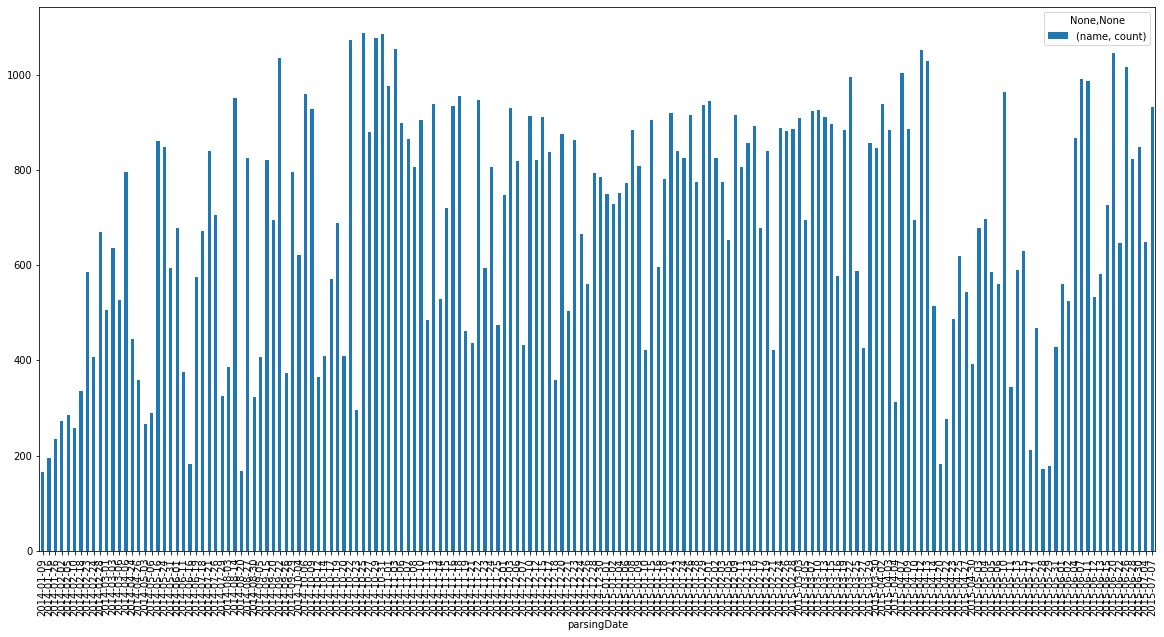

In [107]:
nbVendorbyDate.plot.bar(figsize=(20,10))

We get a plot unusable in the state. There is no visible trend, the data is very noisy. However we might be able to extract some data by watching the first appearance of each pseudo.

## Rating plot (useless)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c3687d190>]],
      dtype=object)

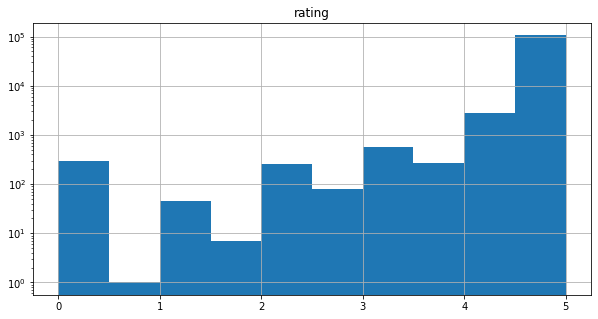

In [109]:
vendorsDF.hist(column='rating',log=True,figsize=(10,5))

The rating of vendors doesn't give much informations

# #Deals

The number of deals could source of intersting data, since it could reveal the ratio of 'new sellers'


## #Products plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c365ae4d0>]],
      dtype=object)

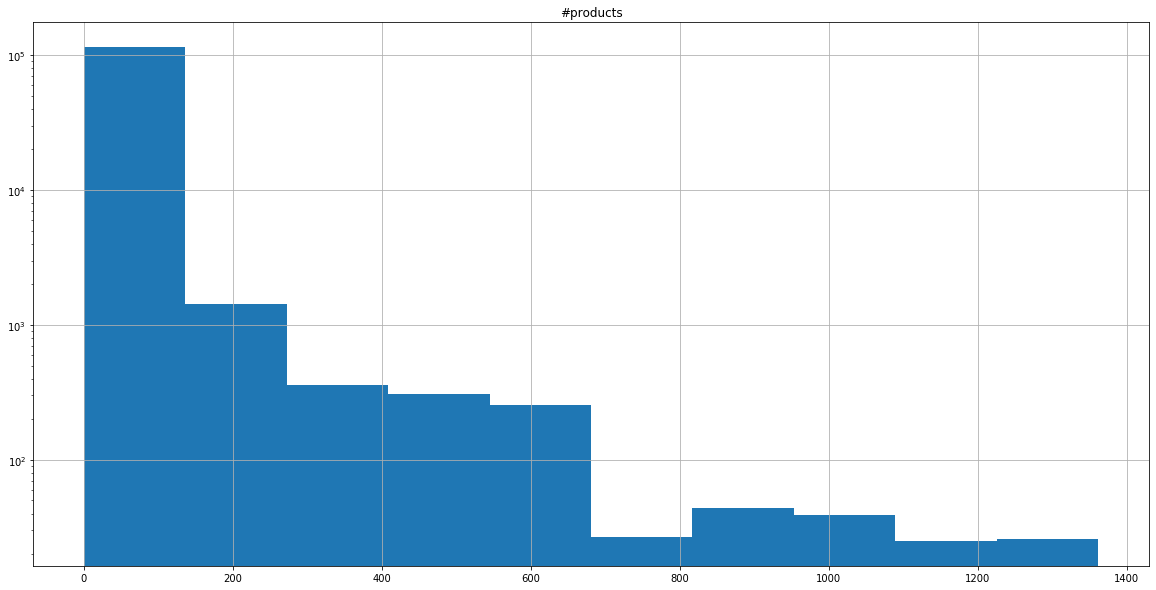

In [110]:
vendorsDF.hist(column='#products',log=True,figsize=(20,10))

This plot shows the huge variation inn the number of products sold by vendors. That means it could be interesting to track the biggest selleres through time since they seam well established.

# BEFORE AFTER ?

In [46]:
vendorsDFbefore = vendorsDF[vendorsDF.parsingDate == dt.datetime.strptime('2014-11-01', '%Y-%m-%d').date() ]
vendorsDFafter = vendorsDF[vendorsDF.parsingDate == dt.datetime.strptime('2015-01-01', '%Y-%m-%d').date() ]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c363ee190>],
      dtype=object)

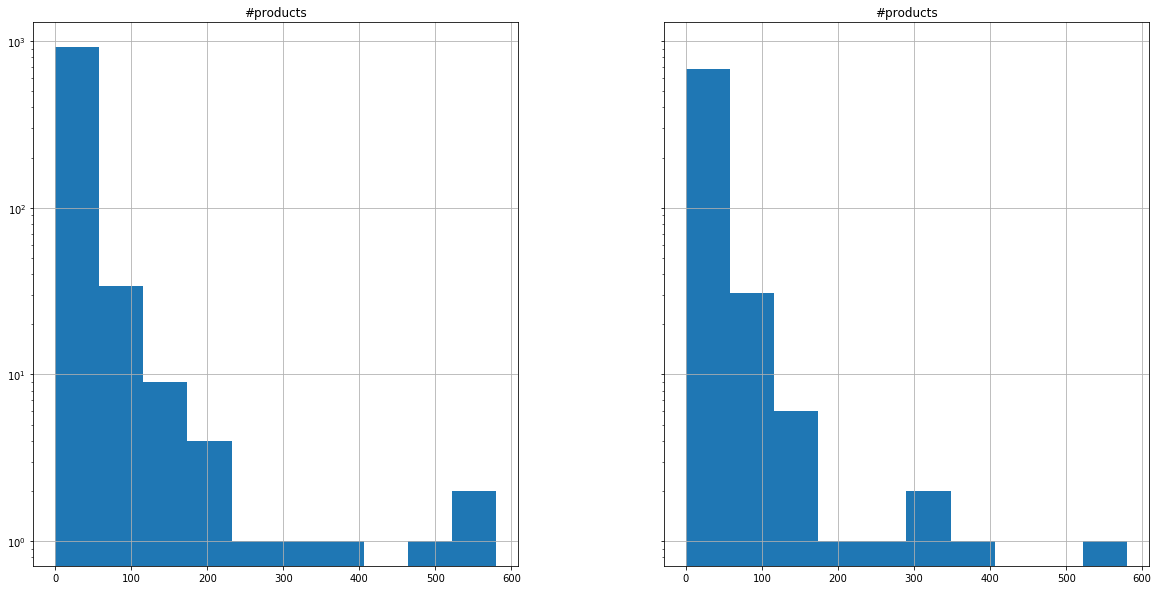

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10),sharey=True)

vendorsDFbefore.hist(column='#products',log=True ,sharey=True,ax=axes[0])
vendorsDFafter.hist(column='#products',log=True,sharey=True,ax=axes[1])

Again this plot is no interest in the state. To compare before/after we need to be very carefull given the noise in the data

In [72]:
vendorsDFbefore.name.agg([ 'count'])

count    977
Name: name, dtype: int64

In [73]:
vendorsDFafter.name.agg([ 'count'])

count    749
Name: name, dtype: int64

Here it might look like a good result, but it is only a coincidence due to the noise